In [1]:
import numpy as np
import pickle
from sklearn import preprocessing
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

labels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

NUM_FILE_BATCHES=5
BATCH_SIZE = 500

with open('data/batches.meta',mode='rb') as file:
    batch=pickle.load(file,encoding='latin1')
label_names=batch['label_names']


def load_cifar10data(filename):
    with open(filename,mode='rb') as file:
        batch=pickle.load(file,encoding='latin1')
        features=batch['data'].reshape((len(batch['data']),3,32,32)).transpose(0,2,3,1)
        labels=batch['labels']
        return features,labels    

x_test_data,test_labels=load_cifar10data('data/test_batch')

unique_labels=list(set(test_labels))
lb=preprocessing.LabelBinarizer()
lb.fit(unique_labels)
y_test=lb.transform(test_labels)

def updateImage(x_train_data,distort=True):
    x_temp=x_train_data.copy()
    x_output=np.zeros(shape=(0,32,32,3))
    for i in range(0,x_temp.shape[0]):
        temp=x_temp[i]
        if distort:
            if random.random()>0.5:
                temp=np.fliplr(temp)
            brightness=random.randint(-63,63)
            temp=temp+brightness
            contrast=random.uniform(0.2,1.8)
            temp=temp*contrast
        mean=np.mean(temp)
        stddev=np.std(temp)
        temp=(temp-mean)/stddev
        temp=np.expand_dims(temp,axis=0)

        x_output=np.append(x_output,temp,axis=0)
    return x_output

x_test=updateImage(x_test_data,False)

In [2]:
save_model_path='./CIFAR10_model'
loaded_graph=tf.get_default_graph()
sess=tf.Session(graph=loaded_graph)
loader=tf.train.import_meta_graph(save_model_path+'.meta')
loader.restore(sess,save_model_path)

In [3]:
loaded_x=loaded_graph.get_tensor_by_name('x:0')
loaded_labels=loaded_graph.get_tensor_by_name('labels:0')
loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
loaded_logits=loaded_graph.get_tensor_by_name('logits:0')
loaded_acc=loaded_graph.get_tensor_by_name('accuracy:0')

In [4]:
validation_accuracy=0.0
for j in range(0,x_test.shape[0]//BATCH_SIZE):
    validation_accuracy+=sess.run(loaded_acc,feed_dict={loaded_x:x_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],loaded_labels:y_test[j*BATCH_SIZE:(j+1)*BATCH_SIZE],loaded_keep_prob:1.0})
validation_accuracy/=(j+1.0)
print('validation_accuracy => %.4f'%validation_accuracy)

validation_accuracy => 0.8124


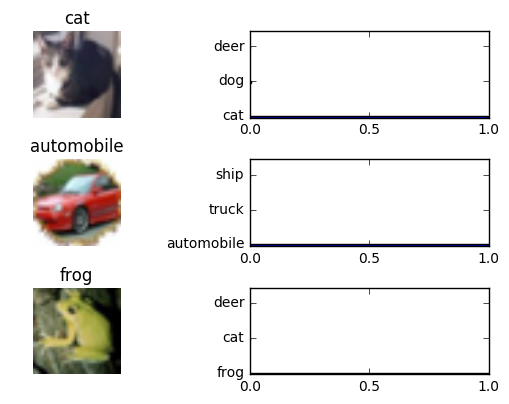

In [100]:
predictions_to_show=3
sampling_size=3
indices=random.sample(range(0,x_test.shape[0]),sampling_size)
#print(indices)
random_test_features=x_test[indices]
random_test_labels=y_test[indices]
random_test_predictions=sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits),predictions_to_show),feed_dict={loaded_x:random_test_features,loaded_labels:random_test_labels,loaded_keep_prob:1.0})
fig,subfigs=plt.subplots(nrows=sampling_size,ncols=2)
fig.tight_layout()
#fig.suptitle('Softmax Predictions',fontsize=10,y=1.05)
y_pos=np.arange(predictions_to_show)
ind=np.arange(predictions_to_show)
margin=0.05
width=(1.0-2.0*margin)/predictions_to_show
for item in range(sampling_size):
    names=[]
    for i in range(0,random_test_predictions[1][item].shape[0]):
        names.append(labels[random_test_predictions[1][item][i]])
    bar_labels=tuple(names)
    subfigs[item][0].imshow(x_test_data[indices[item]])
    subfigs[item][0].set_title(labels[test_labels[indices[item]]])
    subfigs[item][0].set_axis_off()
    #print(random_test_predictions[0][item])
    #subfigs[item][1].barh(y_pos,random_test_predictions[0][item].tolist(),align='center')
    subfigs[item][1].barh(ind,random_test_predictions[0][item],margin,color='blue')
    subfigs[item][1].set_yticks(ind+margin)
    subfigs[item][1].set_yticklabels(bar_labels)
    subfigs[item][1].set_xticks([0,0.5,1.0])